In this assignment we'll learn about `dplyr` and `tidyr`, two packages from the `tidyverse` that allow elegant and easily understandable data tidying and manipulation.
We'll do this by working through the steps of loading an actual dataset, tidying it up, and carrying out some basic analyses.

The dataset we're using comes from the OSF Reproduciblity project replication of a study by Maya Tamir, Christopher Mitchell, and our very own James Gross ("Hedonic and Instrumental Motives in Anger Regulation," Tamir, Mitchell, and Gross, Psychological Science, 2008). You can find the replication report [here](https://osf.io/7i2tf/), and the original paper [here](https://www2.bc.edu/maya-tamir/download/Tamir_et_al_PS_2008.pdf). The replication tests two hypotheses from the original paper:

1) Rating hypothesis: Participants will prefer listening to angry music (or recalling an anger-inducing experience) before playing a confrontational (violent) game, but will prefer listening to exciting or neutral music (or recalling a calm experience) before a neutral game. This is assessed through preference ratings where the participants read a description of a game, and then are asked to rate on a likert scale.

2) Performance hypothesis: Subjects would perform better after listening to angry music on a confrontational game (not one of the ones described in the materials for the previous hypothesis, to avoid contamination), but would perform better on a non-confrontational game (again, not described in the materials for hypothesis 1) after listening to non-angry music. This is computed by having the subjects play without music for 5 minutes, and then after/with music for 5 minutes, and comparing change scores depending on the music type.

First, let's load the libraries we're going to use.

```{r}
library(foreign) # for reading spss formatted data
library(tidyr)
library(dplyr)
library(stringr) # useful for some string manipulation
library(ggplot2)
```


In [363]:
import pandas as pd
import numpy as np
import plotnine as gg
from scipy import stats

# Load Data

```{r}
d = read.spss("data/Tamiretal2008ReplicationData.sav", to.data.frame=T)
```

In [364]:
d = pd.read_spss("data/Tamiretal2008ReplicationData.sav")

Take a look at the data structure:

```{r}
head(d)
```

In [365]:
d.head()

,Subject,Cond,Exper,Inifile,Date,Time,Game1Angry1,Game1Angry2,Game1Angry3,Game1AngryFriends,...,PleasantScoreForNeutralMusic,AngryScoreForAngryMusic,AngryScoreForExcitingMusic,AngryScoreForNeutralMusic,ExcitedScoreForExcitingMusic,ExcitedScoreForNeutralMusic,ActiveScoreForExcitingMusic,ActiveScoreForNeutralMusic,ExcitedScoreForAngryMusic,ActiveScoreForAngryMusic
0,1.0,2.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364282e+10,11:19:41,6.0,6.0,5.0,2.0,...,4.666667,4.333333,3.333333,1.666667,4.000000,2.000000,4.666667,2.000000,3.333333,4.000000
1,2.0,3.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364282e+10,14:05:53,7.0,7.0,7.0,7.0,...,4.000000,5.000000,3.333333,1.333333,3.333333,2.000000,3.666667,1.666667,5.000000,5.000000
2,3.0,1.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364282e+10,15:08:59,6.0,5.0,7.0,2.0,...,1.666667,4.000000,2.333333,1.333333,2.333333,1.666667,2.000000,1.333333,2.666667,4.000000
3,4.0,4.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364291e+10,09:42:32,4.0,1.0,1.0,6.0,...,3.666667,2.666667,1.000000,1.333333,4.000000,1.666667,5.000000,1.666667,2.666667,3.666667
4,5.0,5.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364291e+10,13:38:15,6.0,6.0,7.0,6.0,...,2.333333,2.333333,1.666667,1.000000,3.000000,2.000000,3.000000,1.333333,4.333333,4.666667


This data is what we call **wide form** -- each subject is a single row, and the columns represent different observations. This is a somewhat inconvenient way of representing the data, for example if we wanted to do the same operation to each likert rating (for example normalize it to be in the range 0-1), we'd have to do it on each of the 40 or so rating columns. To avoid this, our eventual goal will be to convert the data into **long form**, where each row is a single observation. 

For now, take a look at the column names to get a better idea of what all is in the dataset.

```{r}
colnames(d)
```


In [366]:
print(list(d.columns))

['Subject', 'Cond', 'Exper', 'Inifile', 'Date', 'Time', 'Game1Angry1', 'Game1Angry2', 'Game1Angry3', 'Game1AngryFriends', 'Game1AngryStrangers', 'Game1CalmFriends', 'Game1CalmStrangers', 'Game1ExcitedFriends', 'Game1ExcitedStrangers', 'Game1Exciting1', 'Game1Exciting2', 'Game1Exciting3', 'Game1Intro', 'Game1Neutral1', 'Game1Neutral2', 'Game1Neutral3', 'Game2Angry1', 'Game2Angry2', 'Game2Angry3', 'Game2AngryFriends', 'Game2AngryStrangers', 'Game2CalmFriends', 'Game2CalmStrangers', 'Game2ExcitedFriends', 'Game2ExcitedStrangers', 'Game2Exciting1', 'Game2Exciting2', 'Game2Exciting3', 'Game2Intro', 'Game2Neutral1', 'Game2Neutral2', 'Game2Neutral3', 'Game3Angry1', 'Game3Angry2', 'Game3Angry3', 'Game3AngryFriends', 'Game3AngryStrangers', 'Game3CalmFriends', 'Game3CalmStrangers', 'Game3ExcitedFriends', 'Game3ExcitedStrangers', 'Game3Exciting1', 'Game3Exciting2', 'Game3Exciting3', 'Game3Intro', 'Game3Neutral1', 'Game3Neutral2', 'Game3Neutral3', 'Game4Angry1', 'Game4Angry2', 'Game4Angry3', 'Game

And see if you can figure out what range the likert scores are in. What's the highest number on the likert scale, and what's the lowest? (Hint, `d$Game1Angry1` is one of the likert rating columns, and you may want to use `unique` or `range` or `hist`)

```{r}
## your code here

```

In [367]:
likert_set = set(d.Game1Angry1[~np.isnan(d.Game1Angry1)])

Highest number: [Your answer here]
Lowest number: [Your answer here]

In [368]:
print(f"Highest number: {max(likert_set)} Lowest number: {min(likert_set)}")

Highest number: 7.0 Lowest number: 1.0



# cleaning up a bit

First, we'll get rid of rows and columns of the data that we don't need.

## filter out excluded rows 

First, we need to `filter` out any rows that should be excluded. According to the report, there are two exclusions:

>> "exclude data from participant 2 and participant 23 
>> participant 2 is female, and this is a males only study 
>> participant 23 was set up on part 2 of the study (the music ratings) twice and never did part 1"

You can see participant 23's data and the fact that they did not do part 1 by looking at the last rows of the dataframe:

```{r}
tail(d)
```

In [369]:
d.tail()

,Subject,Cond,Exper,Inifile,Date,Time,Game1Angry1,Game1Angry2,Game1Angry3,Game1AngryFriends,...,PleasantScoreForNeutralMusic,AngryScoreForAngryMusic,AngryScoreForExcitingMusic,AngryScoreForNeutralMusic,ExcitedScoreForExcitingMusic,ExcitedScoreForNeutralMusic,ActiveScoreForExcitingMusic,ActiveScoreForNeutralMusic,ExcitedScoreForAngryMusic,ActiveScoreForAngryMusic
86,88.0,6.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364463e+10,14:13:57,7.0,7.0,5.0,4.0,...,5.000000,3.666667,2.000000,1.000000,5.000000,3.666667,5.000000,1.666667,5.000000,5.000000
87,89.0,2.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364463e+10,15:04:53,7.0,6.0,6.0,7.0,...,4.333333,4.666667,2.000000,1.000000,4.000000,1.666667,4.666667,1.333333,4.666667,4.000000
88,90.0,3.0,C:\Users\msplab\Desktop\Study 151\Study151Part...,default.mlp,1.364463e+10,16:09:49,5.0,5.0,5.0,7.0,...,4.333333,4.333333,1.666667,1.000000,4.333333,1.333333,5.000000,1.000000,5.000000,4.333333
89,23.0,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,2.666667,2.333333,2.000000,4.333333,3.666667,3.000000,3.333333,4.333333,4.666667
90,23.0,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,...,3.666667,2.333333,2.333333,1.666667,4.000000,3.333333,4.000000,3.333333,3.000000,4.000000


Notice that participant 23 has missing values for part 1.

The researchers have made a column called `DoNotUse` based on their exlusion criteria. Use this column to filter the dataframe! (hint: this is a little trickier than it might be because of how R treats NA values. You may want to check out `?is.na`.)

```{r}
filtered_d = d %>% 
  filter(   ) # your code here: exclude subjects that are marked as "DoNotUse"
```

In [370]:
filtered_d = d[~(d.DoNotUse > 0.5)]

It's good practice to assign a new variable name (in this case `filtered_d`) to a data frame when you change it in an important way, or apply a code chunk that shouldn't be run twice. This helps prevent you seeing different results when you run your code in chunks (and might run one multiple times, or skip it, etc.) vs. knit the document.

## get rid of unnecessary columns

The dataset contains a bunnch of columns we don't care about:

* The dataset contains three subject columns, which are identical except for a single NA which is not mentioned in the protocol, and so is likely an error.
* Columns telling us the path to the executable run for each part of the experiment, we don't really care about that.
* Etc.

To get rid of these, we'll use the `select` function to take only the columns we need.

```{r}
filtered_d = filtered_d %>% 
  select(c("Subject", "Cond"), # Generally important columns for both hypotheses
         contains("Game"), # we want all the game columns for hypothesis 1
         -contains("Intro"), -c("WhichGames", "GameComments"), # except these
         starts_with("DinerDashWith"), c("SOFMusicEnemies", "SOFNoMusicEnemies")) # These columns are for hypothesis 2
```


In [371]:
selected_columns = list(filter(lambda name: "Subject" == name or
                                            "Cond" == name or
                                             ("Game" in name and 
                                              "Intro" not in name and 
                                              "WhichGames" != name and 
                                              "GameComments" != name) or
                                             name.startswith("DinerDashWith") or
                                             "SOFMusicEnemies" == name or
                                             "SOFNoMusicEnemies" == name,
                               filtered_d.columns))

In [372]:
print(selected_columns)

['Subject', 'Cond', 'Game1Angry1', 'Game1Angry2', 'Game1Angry3', 'Game1AngryFriends', 'Game1AngryStrangers', 'Game1CalmFriends', 'Game1CalmStrangers', 'Game1ExcitedFriends', 'Game1ExcitedStrangers', 'Game1Exciting1', 'Game1Exciting2', 'Game1Exciting3', 'Game1Neutral1', 'Game1Neutral2', 'Game1Neutral3', 'Game2Angry1', 'Game2Angry2', 'Game2Angry3', 'Game2AngryFriends', 'Game2AngryStrangers', 'Game2CalmFriends', 'Game2CalmStrangers', 'Game2ExcitedFriends', 'Game2ExcitedStrangers', 'Game2Exciting1', 'Game2Exciting2', 'Game2Exciting3', 'Game2Neutral1', 'Game2Neutral2', 'Game2Neutral3', 'Game3Angry1', 'Game3Angry2', 'Game3Angry3', 'Game3AngryFriends', 'Game3AngryStrangers', 'Game3CalmFriends', 'Game3CalmStrangers', 'Game3ExcitedFriends', 'Game3ExcitedStrangers', 'Game3Exciting1', 'Game3Exciting2', 'Game3Exciting3', 'Game3Neutral1', 'Game3Neutral2', 'Game3Neutral3', 'Game4Angry1', 'Game4Angry2', 'Game4Angry3', 'Game4AngryFriends', 'Game4AngryStrangers', 'Game4CalmFriends', 'Game4CalmStrangers

In [373]:
filtered_d = filtered_d.filter(selected_columns)

Even better, let's split this into separate data frames for hypothesis 1 and hypothesis 2, since they are different types of experiments with different measurements, and therefore different analyses that will need to be performed. Now that we've cleaned up the data, this is pretty easy to do! We'll just drop the columns that are for the other hypothesis. The `select` function lets us choose which columns to remove (instead of which to keep) by putting a minus sign in front of them. First, let's create a dataset for the rating hypothesis by getting rid of the game performance columns:

```{r}
rating_hyp_d = filtered_d %>% 
  filter(is.na(DoNotUseVideoGamePerformanceData)) %>% # first, let's get rid of the subjects who did so poorly on one game that their data is unusable
  select(-DoNotUseVideoGamePerformanceData, # now get rid of that column
         -starts_with("DinerDash"), # and the other columns we don't need
         -starts_with("SOF"))
```


In [374]:
rating_hyp_d = filtered_d[np.isnan(filtered_d.DoNotUseVideoGamePerformanceData)]

In [375]:
rating_hyp_d = rating_hyp_d.filter(regex='^(?!(DinerDash|SOF|DoNotUseVideoGamePerformanceData))')

In [376]:
rating_hyp_d

,Subject,Cond,Game1Angry1,Game1Angry2,Game1Angry3,Game1AngryFriends,Game1AngryStrangers,Game1CalmFriends,Game1CalmStrangers,Game1ExcitedFriends,...,Game4CalmFriends,Game4CalmStrangers,Game4ExcitedFriends,Game4ExcitedStrangers,Game4Exciting1,Game4Exciting2,Game4Exciting3,Game4Neutral1,Game4Neutral2,Game4Neutral3
0,1.0,2.0,6.0,6.0,5.0,2.0,5.0,2.0,2.0,1.0,...,5.0,5.0,7.0,4.0,5.0,5.0,2.0,1.0,5.0,2.0
2,3.0,1.0,6.0,5.0,7.0,2.0,2.0,2.0,2.0,2.0,...,2.0,4.0,4.0,5.0,7.0,4.0,5.0,3.0,2.0,4.0
5,6.0,6.0,5.0,5.0,6.0,3.0,4.0,5.0,4.0,6.0,...,4.0,4.0,5.0,4.0,2.0,4.0,3.0,3.0,5.0,5.0
8,9.0,5.0,4.0,1.0,4.0,7.0,7.0,4.0,5.0,3.0,...,1.0,1.0,4.0,1.0,4.0,7.0,3.0,6.0,2.0,2.0
9,10.0,1.0,7.0,5.0,7.0,6.0,6.0,2.0,2.0,5.0,...,1.0,1.0,6.0,3.0,5.0,6.0,4.0,2.0,4.0,2.0
10,11.0,2.0,3.0,4.0,3.0,3.0,5.0,1.0,2.0,2.0,...,3.0,4.0,3.0,6.0,1.0,4.0,5.0,1.0,5.0,2.0
11,12.0,4.0,5.0,6.0,1.0,7.0,7.0,3.0,3.0,4.0,...,4.0,6.0,7.0,7.0,3.0,4.0,6.0,4.0,5.0,1.0
15,16.0,3.0,4.0,5.0,5.0,4.0,7.0,2.0,1.0,1.0,...,5.0,4.0,7.0,4.0,2.0,2.0,4.0,2.0,3.0,4.0
17,18.0,1.0,7.0,7.0,5.0,5.0,6.0,2.0,3.0,3.0,...,4.0,3.0,7.0,5.0,2.0,2.0,2.0,1.0,2.0,1.0
19,20.0,3.0,5.0,3.0,7.0,6.0,7.0,2.0,2.0,4.0,...,5.0,4.0,3.0,6.0,2.0,4.0,5.0,4.0,5.0,3.0


Now you try! Fill in the selection criteria to get rid of the "Game" columns, which we don't need for the performance hypothesis. (It's simpler than the code block above, because you don't need to do a `filter` first, only a `select`.)

```{r}
performance_hyp_d = filtered_d %>% 
  select( ) # your code here: remove the columns containing "Game" in the name
```

In [377]:
performance_hyp_d = filtered_d.filter(regex='^(?!.*(Game))')

# Converting to long form

Now we want to convert the data to long form, to make the rest of our manipulations easier. To do this, we can `gather` columns. This will take many columns, and change the column names into entries in a "key" column, while the values that were in the original column will be turned into entries in a "value" column. It's easiest to see with an example:

```{r}
tiny_demo_d = head(performance_hyp_d, 2) # get just the first two subjects performance data, for a demo
```


In [378]:
tiny_demo_d = performance_hyp_d.head(2)

First, take a look at the original wide-form data:
```{r}
tiny_demo_d
```

In [379]:
tiny_demo_d

,Subject,Cond,SOFNoMusicEnemies,SOFMusicEnemies,DinerDashWithMusicScore,DinerDashWithoutMusicScore
0,1.0,2.0,22.0,19.0,5830.0,5000.0
2,3.0,1.0,15.0,23.0,5370.0,1250.0


Now, take a look at the long-form version:
```{r}
tiny_demo_d %>% gather(Measurment, Value, 
                       -c("Subject", "Cond")) # this tells it to gather all columns *except* these ones.
```

In [380]:
tiny_demo_d = pd.melt(tiny_demo_d, id_vars=["Subject", "Cond"], var_name="Measurement", value_name="Value")
tiny_demo_d

,Subject,Cond,Measurement,Value
0,1.0,2.0,SOFNoMusicEnemies,22.0
1,3.0,1.0,SOFNoMusicEnemies,15.0
2,1.0,2.0,SOFMusicEnemies,19.0
3,3.0,1.0,SOFMusicEnemies,23.0
4,1.0,2.0,DinerDashWithMusicScore,5830.0
5,3.0,1.0,DinerDashWithMusicScore,5370.0
6,1.0,2.0,DinerDashWithoutMusicScore,5000.0
7,3.0,1.0,DinerDashWithoutMusicScore,1250.0



See how the columns have been converted into rows (except for the two we excluded), and the dataset has gone from wide to long?

Now let's actually convert the performance dataset

```{r}
performance_hyp_long_d = performance_hyp_d %>% 
  gather(Measurement, Score, -c("Subject", "Cond"))
```


In [381]:
performance_hyp_long_d = pd.melt(performance_hyp_d, id_vars=["Subject", "Cond"], var_name="Measurement", value_name="Score")

And you can convert the rating dataset! (Call the "Key" column "Measurement" and call the "Value" column "Rating", so that the code below will work)

```{r}
rating_hyp_long_d = rating_hyp_d %>%
  ## your code here
```

In [382]:
rating_hyp_long_d = pd.melt(rating_hyp_d, id_vars=["Subject", "Cond"], var_name="Measurement", value_name="Rating")

In [383]:
rating_hyp_long_d

,Subject,Cond,Measurement,Rating
0,1.0,2.0,Game1Angry1,6.0
1,3.0,1.0,Game1Angry1,6.0
2,6.0,6.0,Game1Angry1,5.0
3,9.0,5.0,Game1Angry1,4.0
4,10.0,1.0,Game1Angry1,7.0
...,...,...,...,...
2815,84.0,4.0,Game4Neutral3,2.0
2816,85.0,5.0,Game4Neutral3,4.0
2817,86.0,3.0,Game4Neutral3,1.0
2818,88.0,6.0,Game4Neutral3,1.0


In [384]:
print(rating_hyp_long_d.columns)

Index(['Subject', 'Cond', 'Measurement', 'Rating'], dtype='object')


# Splitting columns

The measurement column in each dataset now contains a bunch of different types of information. Really, we would like these to be separate columns. For example, we could have one column telling you which video-game it is, and one telling you whether there was music. Tidyverse contains some handy features for splitting columns, but unfortunately the measurement names here are not well suited to it (if the different types of information were always the same length, or were separated by a symbol like "." or "_", it would be easy). Thus we'll have to do a bit of manual testing. We can use the `mutate` function in dplyr to create new columns as functions of old ones (or alter existing columns). We'll also use the `grepl` function, which lets us test whether a *regular expression* (a fancy type of search pattern) is contained in a column name. For most your purposes, you can probably just use grepl to search for strings, but there are some other quite useful functions in regular expressions, like the "or"" function (`|`) we use below.

```{r}
performance_hyp_long_d = performance_hyp_long_d %>% 
  mutate(ConfrontationalGame = grepl("SOF", Measurement), # create a new variable that will say whether the measurement was of the game soldier of fortune (SOF).
         WithMusic = !grepl("NoMusic|WithoutMusic", Measurement), # creates a new column named WithMusic, which is False if the measurement contains *either* "NoMusic" or "WithoutMusic"
         MusicCondition = factor(ifelse(Cond > 3, Cond-3, Cond), levels = 1:3, labels = c("Anger", "Exciting", "Neutral"))) # Get rid of uninterpretable condition labels

```



In [385]:
performance_hyp_long_d["ConfrontationalGame"] = performance_hyp_long_d.Measurement.str.contains("SOF")
performance_hyp_long_d["WithMusic"] = ~performance_hyp_long_d.Measurement.str.contains("NoMusic|WithoutMusic")

In [386]:
performance_hyp_long_d["MusicCondition"] = performance_hyp_long_d["Cond"].map(lambda cond: ["Anger", "Exciting", "Neutral"][int(cond - 1 if cond <= 3 else cond - 4)])

In [387]:
performance_hyp_long_d.columns

Index(['Subject', 'Cond', 'Measurement', 'Score', 'ConfrontationalGame',
       'WithMusic', 'MusicCondition'],
      dtype='object')

Now you can help! For the rating dataset, write a test on a measurement name, using `grepl` or `%in%` to figure out whether it's a recall or a music rating. Your new `IsRecall` column should be true if the measurement name contain either "Friends" or "Strangers".

```{r}
rating_hyp_long_d = rating_hyp_long_d %>%
  mutate(
    IsRecall = ,## Your code here
  )
```

In [388]:
rating_hyp_long_d['IsRecall'] = rating_hyp_long_d.Measurement.str.contains('Friends|Strangers').astype(int)

Here are a couple other useful ways of manipulating columns. (You won't remember all the functions you see here now, but that's okay. You can always reference this tutorial later if there's something you need to figure out how to do.)

```{r}
rating_hyp_long_d = rating_hyp_long_d %>%
  mutate(
    GameNumber = as.numeric(substr(rating_hyp_long_d$Measurement, 5, 5)),
    ConfrontationalGame = GameNumber <= 2, # in a mutate, we can use a column we created (or changed) right away. Games 1 and 2 are confrontational, games 3 and 4 are not.
    Emotion = str_extract(Measurement, "Angry|Neutral|Excited|Exciting|Calm"),
    Emotion = ifelse(Emotion == "Excited", "Exciting", # this just gets rid of some annoying labeling choices
              ifelse(Emotion == "Calm", "Neutral", Emotion))
    ) 
```

In [389]:
rating_hyp_long_d

,Subject,Cond,Measurement,Rating,IsRecall
0,1.0,2.0,Game1Angry1,6.0,0
1,3.0,1.0,Game1Angry1,6.0,0
2,6.0,6.0,Game1Angry1,5.0,0
3,9.0,5.0,Game1Angry1,4.0,0
4,10.0,1.0,Game1Angry1,7.0,0
...,...,...,...,...,...
2815,84.0,4.0,Game4Neutral3,2.0,0
2816,85.0,5.0,Game4Neutral3,4.0,0
2817,86.0,3.0,Game4Neutral3,1.0,0
2818,88.0,6.0,Game4Neutral3,1.0,0


In [390]:
rating_hyp_long_d['GameNumber'] = pd.to_numeric(rating_hyp_long_d.Measurement.str[4])
rating_hyp_long_d['ConfrontationalGame'] = rating_hyp_long_d.GameNumber <= 2



In [391]:
rating_hyp_long_d['Emotion'] = rating_hyp_long_d.Measurement.str \
                          .extract(r'(Angry|Neutral|Excited|Exciting|Calm)')
rating_hyp_long_d['Emotion'] = rating_hyp_long_d['Emotion'].map(lambda x: "Exciting" if x == "Excited" else
                                                                              "Neutral" if x == "Calm" else x)

# Groups, Summaries, and Results

## Performance Hypothesis

For the performance data, we need to do a little bit of manipulation of the columns in order to get to the performance measures the experimenters actually used. Because they want to compare changes in performance across games that have very different scoring systems, the easiest solution is to compare z-scores. The way they did this was to z-score performance before music, z-score performance after music, and then create a difference measure which is a difference of z-scores. (To my mind, this is actually not quite the correct way to analyze this data, but like the replication we will follow the original authors.)

We'll add a new z-scored value column. However, we have to be careful! We want to z-score within *groups* of the rows, that are all the same type of measurement. For example, we want to z-score the "DinnerDashWithMusic" scores with respect to eachother, but **not** with respect to the scores from the other game, for example. We can use the `group_by` function to set groups, and then all the changes we apply will only occur within those groups until we `ungroup` the dataset.

To make this more concrete, let's see how the `group_by` function can let us compute means within different groups, for example mean scores on the two different games.

```{r}
performance_hyp_long_d %>% 
  group_by(ConfrontationalGame) %>%
  summarize(AvgScore = mean(Score, na.rm=T)) # the na.rm tells R to ignore NA values
```


In [392]:
performance_hyp_long_d.groupby('ConfrontationalGame').Score.mean()

ConfrontationalGame
False    5287.502890
True       18.345029
Name: Score, dtype: float64


This makes it clear why we can't just z-score the games together! The scores are very different between games. So let's z-score within groups (using the `scale` function):

```{r}
performance_hyp_long_d = performance_hyp_long_d %>%
  group_by(ConfrontationalGame, WithMusic) %>% # we're going to compute four sets of z-scores, one for the confrontational game without music, one for the confrontational game with, one for the nonconfrontational game without music, and one for the nonconfrontational game with
  mutate(z_scored_performance = scale(Score)) %>%
  ungroup()
```

In [393]:
performance_hyp_long_d['z_scored_performance'] = performance_hyp_long_d.groupby('ConfrontationalGame').Score.apply(lambda x: (x-x.mean())/x.std())

In [394]:
performance_hyp_long_d.groupby('ConfrontationalGame').z_scored_performance.mean()

ConfrontationalGame
False    1.296330e-16
True     7.141786e-17
Name: z_scored_performance, dtype: float64

In [395]:
performance_hyp_long_d.groupby('ConfrontationalGame').z_scored_performance.std()

ConfrontationalGame
False    1.0
True     1.0
Name: z_scored_performance, dtype: float64



## Rating Hypothesis

The rating hypothesis analysis also requires some grouped manipulation: the experimenters collected repeated measures (ratings in each emotion category and each music/recall category from each game). They then averaged all the ratings that were from a given emotion and game type together to produce a nice summary. Your job is to implement this, calling the new variable MeanRating, and save the summarized data in a new data frame called `rating_summary_d`. (Hint: use a `group_by` and a `summarize`.)


```{r}
rating_summary_d = rating_hyp_long_d %>% 
  ## your code here
```


In [396]:
rating_summary_d = rating_hyp_long_d.groupby(['Emotion', 'IsRecall', 'ConfrontationalGame']).Rating.mean().reset_index()
rating_summary_d = rating_summary_d.rename(columns = {'Rating': "MeanRating"})

Let's take a look at the result:

```{r}
rating_summary_d
```

In [397]:
rating_summary_d

,Emotion,IsRecall,ConfrontationalGame,MeanRating
0,Angry,0,False,3.134752
1,Angry,0,True,4.826241
2,Angry,1,False,2.090426
3,Angry,1,True,4.457447
4,Exciting,0,False,3.230496
5,Exciting,0,True,2.663121
6,Exciting,1,False,5.079787
7,Exciting,1,True,3.622340
8,Neutral,0,False,3.365248
9,Neutral,0,True,1.907801


And a simple bar plot (don't worry too much about what exactly this code is doing):

```{r TamirFig1}
ggplot(rating_summary_d, aes(x=ConfrontationalGame, y=MeanRating, fill=Emotion)) +
  geom_bar(position="dodge", stat="identity") + 
  scale_fill_brewer(palette="Set1")
```


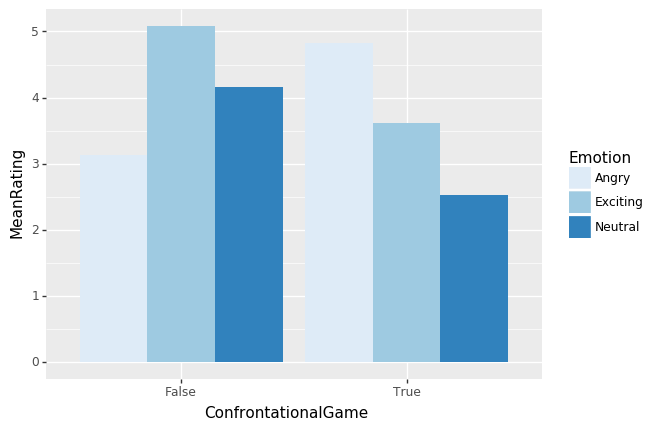

<ggplot: (8774491812658)>

In [398]:
gg.ggplot(data=rating_summary_d, mapping=gg.aes(x="ConfrontationalGame", y="MeanRating", fill="Emotion")) +\
    gg.geom_bar(position="dodge", stat="identity") + \
    gg.scale_fill_brewer(palette="Blues")

Up to reordering (and the fact that we didn't compute error bars), this is a pretty decent replication of Fig. 1 from the original Tamir et al. paper. The ratings were highest for Angry in the confrontational game, and lowest for Angry in the non-confrontational game.

And the long form dataset makes it easy to run a linear model (don't worry too much about this, we'll talk more about it in 252). 

```{r}
model = lm(Rating ~ ConfrontationalGame * Emotion, rating_hyp_long_d)
summary(model)
```

In [399]:
model = stats.linregress(rating_hyp_long_d.Rating, rating_hyp_long_d.ConfrontationalGame)
print(model)

LinregressResult(slope=-0.011107824470753333, intercept=0.5374908770612163, rvalue=-0.04256659053742829, pvalue=0.02379243042826102, stderr=0.004911292940035984)



## Performance Hypothesis (Continued)

There are still a few more steps to go for the performance hypothesis. We need to take a difference score to see how people improved from before hearing the music to after, and then see if the improvement is larger if they heard music congruent with the type of game. 

To compute the difference score, we have to make our data a bit wider. We now want to subtract the pre-music scores from the post-music scores, which is easiest to do if they are in two different columns. To do this we'll use the `spread` function (which is more or less the opposite of `gather`)

```{r}
performance_diff_d = performance_hyp_long_d %>%
  mutate(WithMusic = factor(WithMusic, levels=c(F, T), labels=c("PreMusic", "PostMusic"))) %>% # first, tweak the variable so our code is easier to read.
  select(-c("Score", "Measurement")) %>% # now we remove columns we don't need (bonus: leave them in and see if you can understand what goes wrong!)
  spread(WithMusic, z_scored_performance) %>%
  mutate(ImprovementScore=PostMusic-PreMusic)
```


In [405]:
performance_diff_d = performance_hyp_long_d.copy()
performance_diff_d['WithMusic'] = performance_diff_d.WithMusic.map(lambda level: "PostMusic" if level else "PreMusic")
performance_diff_d = performance_diff_d.drop(["Score", "Measurement"], axis=1)
performance_diff_d = performance_diff_d.set_index(['Subject', 'Cond', 'ConfrontationalGame', 'MusicCondition', "WithMusic"]).z_scored_performance.unstack()
performance_diff_d['ImprovementScore'] = performance_diff_d.PostMusic - performance_diff_d.PreMusic



Let's take a look at the end result:

```{r}
performance_diff_d
```


In [417]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(performance_hyp_long_d)

     Subject  Cond                 Measurement   Score  ConfrontationalGame  \
0        1.0   2.0           SOFNoMusicEnemies    22.0                 True   
1        3.0   1.0           SOFNoMusicEnemies    15.0                 True   
2        4.0   4.0           SOFNoMusicEnemies     3.0                 True   
3        5.0   5.0           SOFNoMusicEnemies    18.0                 True   
4        6.0   6.0           SOFNoMusicEnemies    23.0                 True   
5        7.0   3.0           SOFNoMusicEnemies     7.0                 True   
6        8.0   6.0           SOFNoMusicEnemies    17.0                 True   
7        9.0   5.0           SOFNoMusicEnemies    18.0                 True   
8       10.0   1.0           SOFNoMusicEnemies    16.0                 True   
9       11.0   2.0           SOFNoMusicEnemies    19.0                 True   
10      12.0   4.0           SOFNoMusicEnemies    23.0                 True   
11      13.0   4.0           SOFNoMusicEnemies     2


If you don't understand every step of that code (or any other `dplyr` code), it can be helpful to look at the result of running just the first line, then just the first two lines, and so on.

Now we're finally to reproduce Fig. 2 from Tamir et al., we just need to get the mean differences within each game and each kind of music, and save them to a variable called `MeanImprovementScore`:

```{r}
performance_diff_summary_d = performance_diff_d %>%
  ## Your code here
```

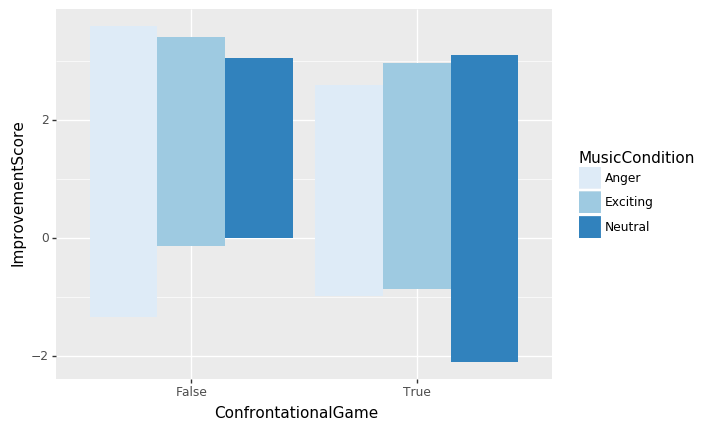

<ggplot: (8774491291782)>

In [419]:
gg.ggplot(data=performance_diff_d.reset_index(), mapping=gg.aes(x="ConfrontationalGame", y="ImprovementScore", fill="MusicCondition")) +\
    gg.geom_bar(position="dodge", stat="identity", na_rm=True) + \
    gg.scale_fill_brewer(palette="Blues")